In [21]:
import pandas as pd
from tst import Transformer

original_data_path = "../../data/SP500_all_time_more_data.csv"
#original_data_path = "../../data/SP500_all_time.csv"
#original_data_path = "../../data/main.csv"
df = pd.read_csv(original_data_path)
# turn all columns into lowercase
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,open,high,low,close,adj close,volume,dff,dtb3,dgs10,dfii10,dgs1,dgs2,dgs5,dfii5,bamlh0a0hym2
0,2003-01-02,879.820007,909.030029,879.820007,909.030029,909.030029,1229200000,1.30,1.20,4.07,2.43,1.42,1.80,3.05,1.75,8.65
1,2003-01-03,909.030029,911.250000,903.070007,908.590027,908.590027,1130800000,1.12,1.20,4.05,2.43,1.41,1.79,3.03,1.75,8.57
2,2003-01-06,908.590027,931.770020,908.590027,929.010010,929.010010,1435900000,1.22,1.19,4.09,2.46,1.44,1.84,3.10,1.79,8.41
3,2003-01-07,929.010010,930.809998,919.929993,922.929993,922.929993,1545200000,1.20,1.17,4.04,2.42,1.40,1.77,3.04,1.76,8.26
4,2003-01-08,922.929993,922.929993,908.320007,909.929993,909.929993,1467600000,1.29,1.17,4.00,2.29,1.36,1.71,3.01,1.68,8.18


In [22]:
import plotly.graph_objects as go
# Line plot on the closing prices only
fig = go.Figure(data=go.Scatter(x=df.index, y=df['close'], mode='lines'))
fig.update_layout(title='Closing Prices', xaxis_title='Time', yaxis_title='Price')
fig.show()

In [23]:
def calculate_profit(actions, trade_fee, prices, starting_balance):
    balance = starting_balance
    holding = 0  # Initially, not holding any stock

    for action, price in zip(actions, prices):
        if action == 1:  # Buy
            if balance > trade_fee:
                shares = (balance - trade_fee) / price  # Calculate the number of shares we can buy
                holding += shares  # Update the holding
                balance -= (shares * price) + trade_fee  # Update the balance
        elif action == 0 and holding > 0:  # Sell
            balance += holding * price - trade_fee  # Update the balance
            holding = 0  # No longer holding any stock

    # If holding any stock at the end, sell it at the last price
    if holding > 0:
        balance += holding * prices.iloc[-1] - trade_fee
        holding = 0

    # The final balance after all trades is the net profit
    net_profit = balance - starting_balance
    return net_profit

In [24]:
def calculate_metrics(actions, trade_fee, prices, starting_balance, risk_free_rate):
    balance = starting_balance
    holding = 0
    trades = []

    for action, price in zip(actions, prices):
        if action == 1:  # Buy
            if balance > trade_fee:
                shares = (balance - trade_fee) / price
                holding += shares
                balance -= (shares * price) + trade_fee
                trades.append((-shares * price) - trade_fee)  # Negative cash flow for buying
        elif action == 0 and holding > 0:  # Sell
            balance += holding * price - trade_fee
            trades.append((holding * price) - trade_fee)  # Positive cash flow for selling
            holding = 0

    if holding > 0:
        balance += holding * prices.iloc[-1] - trade_fee
        trades.append((holding * prices.iloc[-1]) - trade_fee)
        holding = 0

    net_profit = balance - starting_balance
    returns = np.array(trades) / starting_balance
    sharpe_ratio = (np.mean(returns) - risk_free_rate) / np.std(returns)

    return {
        'net_profit': net_profit,
        'sharpe_ratio': sharpe_ratio,
        'total_trades': len(trades),
        'avg_return_per_trade': np.mean(returns),
        'max_drawdown': np.min(np.cumsum(returns)),
        'final_balance': balance
    }

In [25]:
import numpy as np
from plotly.subplots import make_subplots
from numpy import RankWarning
import warnings

# Assuming df is your DataFrame with 'close' column and dates in index
x = np.arange(len(df))
y = df['close'].values

# degrees in a range from 1 to 60
degrees = range(1, 61)

# Calculate the profit for each degree
profits = {}
for degree in degrees:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', RankWarning)
        warnings.simplefilter('ignore', RuntimeWarning)
        coeffs = np.polyfit(x, y, degree)
    fitted_line = np.polyval(coeffs, x)
    derivative_coeffs = np.polyder(coeffs)
    derivative_line = np.polyval(derivative_coeffs, x)
    actions = np.where(derivative_line > 0, 1, 0)
    #profit = calculate_profit(actions, 15, df['close'], 1000000)
    profit = calculate_metrics(actions, 15, df['close'], 1000000, 0.01)['net_profit']
    profits[degree] = profit
    
# Find the degree with the highest profit
degree = max(profits, key=profits.get)
print(f"Degree with the highest profit: {degree}")
print(f"Profit: {profits[degree]}")
with warnings.catch_warnings():
    warnings.simplefilter('ignore', RankWarning)
    warnings.simplefilter('ignore', RuntimeWarning)
    coeffs = np.polyfit(x, y, degree)
fitted_line = np.polyval(coeffs, x)
derivative_coeffs = np.polyder(coeffs)
derivative_line = np.polyval(derivative_coeffs, x)
df['action'] = np.where(derivative_line > 0, 1, 0)

# Create subplots: 3 rows, 1 column
fig = make_subplots(rows=3, cols=1, subplot_titles=('Closing Prices with Polynomial Fit', 'Derivative', 'Closing Prices with Action Markers'))

# Scatter plot for the closing prices and fitted line on the first subplot
fig.add_trace(go.Scatter(x=df.index, y=df['close'], mode='lines', name='Closing Prices'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=fitted_line, mode='lines', name='Fitted Line'), row=1, col=1)

# Scatter plot for the derivative line on the second subplot
fig.add_trace(go.Scatter(x=df.index, y=derivative_line, mode='lines', name='Derivative'), row=2, col=1)

# Scatter plot with action markers for the third subplot
fig.add_trace(go.Scatter(x=df.index, y=df['close'], mode='markers', marker=dict(color=df['action'], size=5, colorscale=['red', 'green']), name='Action Markers'), row=3, col=1)

# Update layout for a neat look
fig.update_layout(title='Closing Prices Analysis', xaxis_title='Time', yaxis_title='Price', height=900)

# Adjust layout for subplot titles and axes
fig['layout']['xaxis']['title'] = 'Time'
fig['layout']['xaxis2']['title'] = 'Time'
fig['layout']['xaxis3']['title'] = 'Time'
fig['layout']['yaxis']['title'] = 'Price'
fig['layout']['yaxis2']['title'] = 'Derivative'
fig['layout']['yaxis3']['title'] = 'Price'

fig.show()

Degree with the highest profit: 36
Profit: 10955307.856999239


In [26]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import ta

# Assuming your DataFrame is named 'df' and contains 'close', 'volume', 'high', and 'low' columns
df['index'] = df.index.astype(int)
df['log_volume'] = np.log(df['volume'] + 1)
df['pct_change'] = df['close'].pct_change()
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# introduce seasonal features
df['sin_day'] = np.sin(2 * np.pi * df['day']/365)
df['cos_day'] = np.cos(2 * np.pi * df['day']/365)

# add indicators
df['sma_10'] = ta.trend.sma_indicator(df['close'], window=10)
df['sma_30'] = ta.trend.sma_indicator(df['close'], window=30)
df['ema_10'] = ta.trend.ema_indicator(df['close'], window=10)
df['ema_30'] = ta.trend.ema_indicator(df['close'], window=30)
df['rsi'] = ta.momentum.rsi(df['close'], window=14)
df['macd'] = ta.trend.macd(df['close'], window_slow=26, window_fast=12)
df['macd_signal'] = ta.trend.macd_signal(df['close'], window_slow=26, window_fast=12)
df['macd_diff'] = ta.trend.macd_diff(df['close'], window_slow=26, window_fast=12)
df['bollinger_high'] = ta.volatility.bollinger_hband(df['close'], window=20, window_dev=2)
df['bollinger_low'] = ta.volatility.bollinger_lband(df['close'], window=20, window_dev=2)
df['stoch'] = ta.momentum.stoch(df['high'], df['low'], df['close'], window=14, smooth_window=3)
df['stoch_signal'] = ta.momentum.stoch_signal(df['high'], df['low'], df['close'], window=14, smooth_window=3)
df['adx'] = ta.trend.adx(df['high'], df['low'], df['close'], window=14)

df['ratio_from_first'] = df['close'] / df['close'].iloc[0]

# get the target
df['next_close'] = df['close'].shift(-1)
df['next_pct_change'] = df['pct_change'].shift(-1)

# 1_day_decision
df['1_day_decision'] = df['next_close'] > df['close']
# turn the boolean into 1 and 0
df['1_day_decision'] = df['1_day_decision'].astype(int)


#columns_to_ignore = ['index', 'date', 'next_close', 'close', 'open', 'high', 'low', 'average']
columns_to_ignore = ['index', 'date', 'next_close', 'next_pct_change', '1_day_decision', 'action']
target_column = 'action'

# Drop any missing values from the DataFrame
data = df.dropna()

In [27]:
# scroll to the right to see the new columns
pd.set_option('display.max_columns', None)

data.head()

,date,open,high,low,close,adj close,volume,dff,dtb3,dgs10,dfii10,dgs1,dgs2,dgs5,dfii5,bamlh0a0hym2,action,index,log_volume,pct_change,day,month,year,sin_day,cos_day,sma_10,sma_30,ema_10,ema_30,rsi,macd,macd_signal,macd_diff,bollinger_high,bollinger_low,stoch,stoch_signal,adx,ratio_from_first,next_close,next_pct_change,1_day_decision
33,2003-02-20,845.130005,849.369995,836.559998,837.099976,837.099976,1194100000,1.25,1.17,3.85,1.91,1.29,1.59,2.82,1.13,8.51,1,33,20.900659,-0.009502,20,2,2003,0.337523,0.941317,833.734998,867.748665,839.341877,859.777311,41.256527,-15.046713,-17.885887,2.839174,877.863376,813.025625,52.802020,63.436596,33.867578,0.920872,848.169983,0.013224,1
34,2003-02-21,837.099976,852.280029,831.479980,848.169983,848.169983,1398200000,1.21,1.17,3.90,1.93,1.31,1.63,2.86,1.13,8.42,1,34,21.058452,0.013224,21,2,2003,0.353676,0.935368,834.736994,865.689998,840.946987,859.028451,46.466427,-13.357362,-16.980182,3.622820,869.679112,817.292885,71.773742,63.398332,32.679394,0.933049,832.580017,-0.018381,0
35,2003-02-24,848.169983,848.169983,832.159973,832.580017,832.580017,1229200000,1.25,1.19,3.86,1.87,1.28,1.60,2.82,1.04,8.41,1,35,20.929629,-0.018381,24,2,2003,0.401488,0.915864,835.025995,862.523665,839.425720,857.322101,40.957297,-13.125220,-16.209190,3.083970,867.291362,816.798634,47.506372,57.360711,31.576081,0.915899,838.570007,0.007194,1
36,2003-02-25,832.580017,839.549988,818.539978,838.570007,838.570007,1483700000,1.28,1.18,3.81,1.84,1.27,1.58,2.77,1.00,8.45,1,36,21.117805,0.007194,25,2,2003,0.417194,0.908818,835.285999,859.556999,839.270136,856.112288,43.718359,-12.315933,-15.430539,3.114606,866.760825,816.438174,58.330346,59.203486,31.358383,0.922489,827.549988,-0.013141,0
37,2003-02-26,838.570007,840.099976,826.679993,827.549988,827.549988,1374400000,1.28,1.19,3.78,1.84,1.27,1.57,2.75,1.01,8.44,1,37,21.041283,-0.013141,26,2,2003,0.432776,0.901502,835.120996,856.266665,837.139200,854.269559,40.011269,-12.420614,-14.828554,2.407940,864.658338,815.441662,45.641911,50.492876,31.102072,0.910366,837.280029,0.011758,1


In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Prepare the data for linear regression
# everything except date and next_close
features = data.drop(columns=columns_to_ignore).columns
target = target_column

# Split the data into training, validation, and testing sets
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

# Scale the features and target using only the training data
scaler_features = StandardScaler()
train_features = scaler_features.fit_transform(train_data[features])
val_features = scaler_features.transform(val_data[features])
test_features = scaler_features.transform(test_data[features])

scaler_target = StandardScaler()
train_target = scaler_target.fit_transform(train_data[[target]])
val_target = scaler_target.transform(val_data[[target]])
test_target = scaler_target.transform(test_data[[target]])

# Create the input sequences and corresponding labels for the LSTM model
def create_sequences(features, target, seq_length):
    X = []
    y = []
    for i in range(len(features) - seq_length):
        X.append(features[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Number of previous days to use as input
X_train, y_train = create_sequences(train_features, train_target, seq_length)
X_val, y_val = create_sequences(val_features, val_target, seq_length)
X_test, y_test = create_sequences(test_features, test_target, seq_length)

In [29]:
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Converting data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)  # Transposing to match model's input shape
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

print(X_train_tensor)

tensor([[[-1.4513, -1.4608, -1.4514,  ...,  0.0504,  1.4738, -1.4703],
         [-1.4698, -1.4541, -1.4631,  ...,  0.0491,  1.3171, -1.4448],
         [-1.4444, -1.4635, -1.4615,  ..., -0.1621,  1.1716, -1.4806],
         ...,
         [-1.4605, -1.4539, -1.4602,  ...,  0.1936,  0.7483, -1.4755],
         [-1.4751, -1.4928, -1.4850,  ..., -0.1890,  0.6806, -1.5050],
         [-1.5046, -1.5056, -1.4918,  ..., -0.4718,  0.6429, -1.4869]],

        [[-1.4698, -1.4541, -1.4631,  ...,  0.0491,  1.3171, -1.4448],
         [-1.4444, -1.4635, -1.4615,  ..., -0.1621,  1.1716, -1.4806],
         [-1.4802, -1.4833, -1.4928,  ..., -0.0977,  1.1429, -1.4669],
         ...,
         [-1.4751, -1.4928, -1.4850,  ..., -0.1890,  0.6806, -1.5050],
         [-1.5046, -1.5056, -1.4918,  ..., -0.4718,  0.6429, -1.4869],
         [-1.4865, -1.5057, -1.4898,  ..., -0.9678,  0.6079, -1.5047]],

        [[-1.4444, -1.4635, -1.4615,  ..., -0.1621,  1.1716, -1.4806],
         [-1.4802, -1.4833, -1.4928,  ..., -0

In [30]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create a DataLoader for training data
batch_size = 64  # Adjust the batch size as needed
dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Transformer(
  (layers_encoding): ModuleList(
    (0-3): 4 x Encoder(
      (_selfAttention): MultiHeadAttention(
        (_W_q): Linear(in_features=32, out_features=64, bias=True)
        (_W_k): Linear(in_features=32, out_features=64, bias=True)
        (_W_v): Linear(in_features=32, out_features=64, bias=True)
        (_W_o): Linear(in_features=64, out_features=32, bias=True)
      )
      (_feedForward): PositionwiseFeedForward(
        (_linear1): Linear(in_features=32, out_features=2048, bias=True)
        (_linear2): Linear(in_features=2048, out_features=32, bias=True)
      )
      (_layerNorm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (_layerNorm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (_dopout): Dropout(p=0.2, inplace=False)
    )
  )
  (layers_decoding): ModuleList(
    (0-3): 4 x Decoder(
      (_selfAttention): MultiHeadAttention(
        (_W_q): Linear(in_features=32, out_features=64, bias=True)
        (_W_k): Linear(in_features=3

[Epoch   1/20]:   2%|▏         | 64/3671 [00:00<00:07, 512.00it/s, loss=0.769]

[Epoch  20/20]: 100%|██████████| 3671/3671 [00:07<00:00, 499.57it/s, loss=0.576]

Training complete.


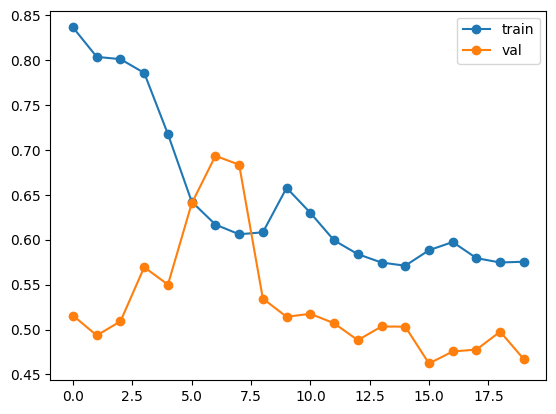

In [31]:
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

d_input = 36 # this one should be 4 assume it is 'Volume','Open', 'Close', 'Scaled_sentiment'
d_output = 1 # prediction length be 3, this is confirmed
d_model = 32 # Lattent dim
q = 8 # Query size
v = 8 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
attention_size = 30 # Attention window size
dropout = 0.2 # Dropout rate
pe = 'regular' # Positional encoding
chunk_mode = None
# Creating sequences
epochs = 20

# Creating the model
model = Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, dropout=dropout, chunk_mode=chunk_mode, pe=pe).to(device)
# model = TimeSeriesTransformer(num_features, num_outputs, dim_val, n_heads, n_decoder_layers, dropout_rate).to(device)
print(model)
# Loss function and optimizer
loss_function = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


# # Training parameters
# num_batches = int(len(X_train) / batch_size)

# # Training loop
# model.train()
# for epoch in range(epochs):
#   total_loss = 0
#   with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {epoch+1:3d}/{epochs}]") as pbar:
#     for b, (x, y) in enumerate(dataloader_train):
#         start_index = b * batch_size
#         end_index = start_index + batch_size
#         x_batch = X_train_tensor[start_index:end_index]
#         y_batch = y_train_tensor[start_index:end_index]

#         # print('x_batch',x_batch.shape)
#         # print('y_batch',y_batch.shape)

#         # Forward pass
#         y_pred = model(x_batch)

#         # print('y_pred',y_pred.shape)

#         loss = loss_function(y_pred, y_batch)

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#   print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / num_batches}")

# print("Training complete.")

model.train()
# Prepare loss history
train_hist_loss = np.zeros(epochs)
val_hist_loss = np.zeros(epochs)

for idx_epoch in range(epochs):
    running_loss = 0
    with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {idx_epoch+1:3d}/{epochs}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader_train):
            optimizer.zero_grad()
            # Propagate input
            netout = model(x.to(device))

            # Compute loss
            loss = loss_function(y.to(device), netout)

            # Backpropagate loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
        
        train_loss = running_loss/len(dataloader_train)
        pbar.set_postfix({'loss': train_loss})
        
        train_hist_loss[idx_epoch] = train_loss
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val, y_val in dataloader_val:
                y_pred_val = model(x_val.to(device))
                val_loss += loss_function(y_val.to(device), y_pred_val).item()
        val_loss /= len(dataloader_val)
        val_hist_loss[idx_epoch] = val_loss
        
        model.train()
        
print("Training complete.")

plt.plot(train_hist_loss, 'o-', label='train')
plt.plot(val_hist_loss, 'o-', label='val')
plt.legend()
plt.show()

Test set evaluation:
Accuracy: 0.64
Classification Report:                precision    recall  f1-score   support

           0       0.00      0.00      0.00       279
           1       0.64      1.00      0.78       501

    accuracy                           0.64       780
   macro avg       0.32      0.50      0.39       780
weighted avg       0.41      0.64      0.50       780



c:\Users\kmfoc\My Drive\BU Files\BU Masters\Work\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\kmfoc\My Drive\BU Files\BU Masters\Work\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\kmfoc\My Drive\BU Files\BU Masters\Work\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



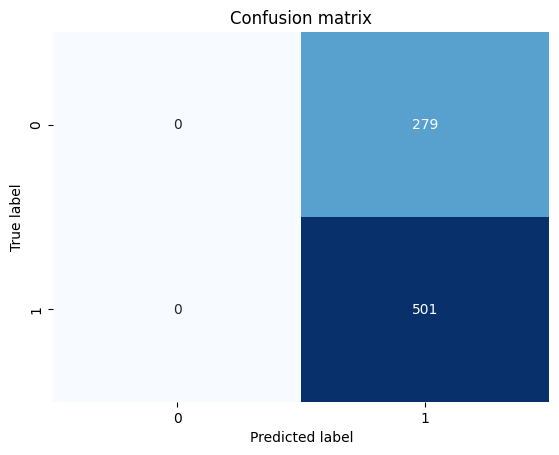

In [32]:
# Evaluate the model on the test set
model.eval()
y_pred_list = []
with torch.no_grad():
    for x_test, _ in dataloader_test:
        y_pred = model(x_test.to(device))
        y_pred_list.append(y_pred.cpu().numpy())

y_pred_arr = np.concatenate(y_pred_list, axis=0)
y_pred_arr = y_pred_arr.reshape(-1)

# Reverse scaling of the predicted values
y_pred_scaled = scaler_target.inverse_transform(y_pred_arr.reshape(-1, 1)).flatten()

# Apply a threshold to convert predicted probabilities to binary labels
threshold = 0.5
y_pred_binary = (y_pred_scaled > threshold).astype(int)

# Convert true labels to binary format
y_test_binary = scaler_target.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1)).flatten().astype(int)

# Calculate evaluation metrics
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test_binary, y_pred_binary)
classification_rep = classification_report(y_test_binary, y_pred_binary)

print("Test set evaluation:")
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report: ", classification_rep)

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_binary, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [33]:
y_pred = y_pred_binary
y_test = y_test_binary

In [34]:
print("fitted_metrics: ", calculate_metrics(y_test, 15, test_data['close'], 1000000, 0.01))

fitted_metrics:  {'net_profit': 717907.3242879552, 'sharpe_ratio': 0.07902829230661282, 'total_trades': 6, 'avg_return_per_trade': 0.11965122071465921, 'max_drawdown': -1.0, 'final_balance': 1717907.3242879552}


In [35]:
print("model_metrics: ", calculate_metrics(y_pred, 15, test_data['close'], 1000000, 0.01))

model_metrics:  {'net_profit': 358360.22610206204, 'sharpe_ratio': 0.14347266475966208, 'total_trades': 2, 'avg_return_per_trade': 0.179180113051031, 'max_drawdown': -1.0, 'final_balance': 1358360.226102062}


In [36]:
print("buy_and_hold_metrics: ", calculate_metrics(np.ones(len(y_test)), 15, test_data['close'], 1000000, 0.01))

buy_and_hold_metrics:  {'net_profit': 358360.22610206204, 'sharpe_ratio': 0.14347266475966208, 'total_trades': 2, 'avg_return_per_trade': 0.179180113051031, 'max_drawdown': -1.0, 'final_balance': 1358360.226102062}


In [37]:
print("fitted_profit: ", calculate_profit(y_test, 15, test_data['close'], 1000000))
print("model_profit: ", calculate_profit(y_pred, 15, test_data['close'], 1000000))
print("buy_and_hold_profit: ", calculate_profit([1]*len(y_test), 15, test_data['close'], 1000000))

fig = make_subplots(rows=2, cols=1, subplot_titles=('Fitted Actions', 'Model Actions'))

fig.add_trace(go.Scatter(x=test_data.index, y =test_data['close'], mode='markers', marker=dict(color=y_test, size=5, colorscale=['red', 'green']), name='Action Markers'), row=1, col=1)

fig.add_trace(go.Scatter(x=test_data.index, y=test_data['close'], mode='markers', marker=dict(color=y_pred, size=5, colorscale=['red', 'green']), name='Action Markers'), row=2, col=1)

fig.update_layout(title='Actions Analysis', xaxis_title='Time', yaxis_title='Action', height=900)

fig['layout']['xaxis']['title'] = 'Time'
fig['layout']['xaxis2']['title'] = 'Time'
fig['layout']['yaxis']['title'] = 'Action'
fig['layout']['yaxis2']['title'] = 'Action'

fig.show()

fitted_profit:  717907.3242879552
model_profit:  358360.22610206204
buy_and_hold_profit:  358360.22610206204
